# Configuraciones iniciales

## Constantes

In [1]:
NOTEBOOK = 5
CLEAN_LOGS = False  # If you want to clean the logs directory
SAVE_FIGS = True  # If you want to save the figures.

# MCMC Configurations
RUN_MCMC = False
BURN = 5_000
NUM_SAMPLES = 100_000
N_WALKERS = 32

# Posterior
N_DATA = 10

REPORT_EVERY = 100  # To report at the logger
MAX_ITER = 5_000  # MAx number of iterations for the SGDW
BATCH_SIZE = 1
PROJ_EVERY = None

# MAX_ITER = 50; REPORT_EVERY = 5  # Descomentar para debuguear
# BURN = 200
# NUM_SAMPLES = 1_000
# N_WALKERS = 2

In [2]:
import random

import numpy as np
import torch

SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True

In [3]:
from pathlib import Path
from icecream import ic


DS_NAME = "data"

CURR_PATH = Path().absolute()
ic(CURR_PATH)
BASE_PATH = CURR_PATH.parent.parent
ic(BASE_PATH)
DATA_PATH = BASE_PATH / "data"
ic(DATA_PATH)
WGAN_PATH = BASE_PATH / "wgan_gp"
ic(WGAN_PATH)
NETS_PATH = WGAN_PATH / "networks" 
ic(NETS_PATH)
IMGS_PATH = CURR_PATH / "imgs" / f"notebook-{NOTEBOOK:02d}"
IMGS_PATH.mkdir(parents=True, exist_ok=True)
ic(IMGS_PATH)
MCMC_PATH = BASE_PATH / "saved_mcmc"
ic(MCMC_PATH)
NUTS_PATH = MCMC_PATH / "NUTS"
ic(NUTS_PATH)

ic| CURR_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/03-sgdw')
ic| BASE_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters')
ic| DATA_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/data')
ic| WGAN_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/wgan_gp')
ic| NETS_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/wgan_gp/networks')
ic| IMGS_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/03-sgdw/imgs/notebook-05')
ic| MCMC_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/saved_mcmc')
ic| NUTS_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasser

PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/saved_mcmc/NUTS')

In [4]:
def save_fig(fig, name_to_save):
    if SAVE_FIGS:
        PATH_TO_SAVE = IMGS_PATH / name_to_save
        fig.savefig(PATH_TO_SAVE.with_suffix(".pdf"))
        fig.savefig(PATH_TO_SAVE.with_suffix(".png"))

## Importaciones generales

In [5]:
from icecream import ic
from bwb.sgdw import sgdw
from bwb.distributions import *
import bwb.utils.plotters as plotters
import matplotlib.pyplot as plt
from bwb.distributions.posterior_samplers import NUTSPosteriorSampler

## Configuraciones 

In [6]:
from bwb.config import conf

conf.use_gpu()
conf.use_single_precision()
conf.set_eps(1e-16)
conf

Config(dtype=torch.float32, device=cuda:0, eps=1.00e-16)

## Configuración del Logger

In [7]:
import time
from pathlib import Path


# Create the logs directory
LOG_PATH = Path("logs") / f"notebook-{NOTEBOOK:02d}_{time.strftime('%Y%m%d_%H%M%S')}.log"
if not LOG_PATH.parent.exists():
    LOG_PATH.parent.mkdir()

# Clean the logs
if CLEAN_LOGS:
    for log_file in Path("logs").glob(f"notebook-{NOTEBOOK:02d}*.log"):
        log_file.unlink()

In [8]:
import logging as logging_
import bwb._logging as logging
from bwb._logging import log_config


# Remove the handlers
log_config.remove_all_handlers()
ic(log_config.loggers)

# Define and add FileHandler
fh = logging_.FileHandler(LOG_PATH)
log_config.set_default_formatter(fh)
log_config.add_handler(fh)


_log = log_config.get_logger("notebook")
log_config.set_level(level=logging.DEBUG, name="notebook")
log_config.set_level(level=logging.DEBUG, name="bwb.sgdw.sgdw")
log_config.set_level(level=logging.DEBUG, name="bwb.sgdw.plotters")

ic| log_config.loggers: {'bwb.config': <Logger bwb.config (WARNING)>,
                         'bwb.distributions.discrete_distribution': <Logger bwb.distributions.discrete_distribution (WARNING)>,
                         'bwb.distributions.distribution_samplers': <Logger bwb.distributions.distribution_samplers (WARNING)>,
                         'bwb.distributions.posterior_samplers': <Logger bwb.distributions.posterior_samplers (WARNING)>,
                         'bwb.distributions.utils': <Logger bwb.distributions.utils (WARNING)>,
                         'bwb.pot.transports': <Logger bwb.pot.transports (WARNING)>,
                         'bwb.sgdw.plotters': <Logger bwb.sgdw.plotters (WARNING)>,
                         'bwb.sgdw.sgdw': <Logger bwb.sgdw.sgdw (WARNING)>,
                         'bwb.sgdw.utils': <Logger bwb.sgdw.utils (WARNING)>,
                         'bwb.utils.autocorr': <Logger bwb.utils.autocorr (WARNING)>,
                         'bwb.utils.plotters':

Esta celda es para configurar la información mostrada en el logger

In [9]:
# Set the default options for the report
INCLUDE_OPTIONS: sgdw.ReportOptions = {
    "dt": False,
    "dt_per_iter": True,
    "iter": True,
    "step_schd": True,
    "total_time": True,
    "w_dist": False,
}

sgdw.Report.INCLUDE_OPTIONS = INCLUDE_OPTIONS

## Obtención del dataset

ic| file_path: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/wgan_gp/dataset/cleaned/data.npy')
ic| len(dataset): 195479


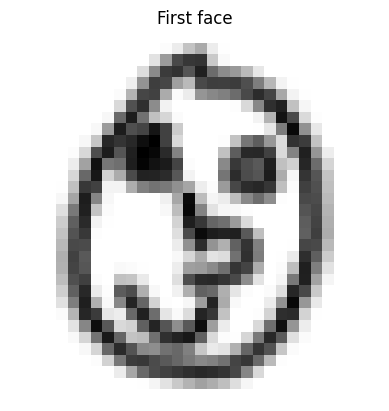

In [10]:
# You can use the wrapper to transform the usual DataSet into a model set
from bwb.distributions.models import ModelDataset
import quick_torch as qt
import torchvision.transforms.v2 as T

transform_ds = T.Compose([
    T.Resize((32, 32)),
    T.ToImage(),
    T.ToDtype(conf.dtype, scale=True),
    T.Lambda(lambda x: x.squeeze()),
])

def get_ds(file_path, transform=transform_ds):
    ic(file_path)
    categories = [qt.Category.FACE]
    dataset_ = qt.QuickDraw(
        root=DATA_PATH,
        categories=categories,
        transform=transform,
        download=True,
        recognized=True,
    )
    path_dataset = Path(file_path)
    dataset_.data = np.load(path_dataset).reshape(-1, 28, 28)
    dataset_.targets = np.ones(len(dataset_.data), dtype=int)
    dataset = dataset_.get_train_data()
    ic(len(dataset))

    return ModelDataset(dataset)

DS_PATH = WGAN_PATH / "dataset" / "cleaned" / f"{DS_NAME}.npy"
ds_models = get_ds(DS_PATH)
ds_dist_sampler = UniformDiscreteSampler().fit(ds_models)

first_face = ds_models.get(0)
fig, _ = plotters.plot_draw(first_face, title="First face")
save_fig(fig, "first_face")

In [11]:
ds_models

ModelDataset(device=cuda:0, dtype=torch.float32, dataset=Dataset QuickDraw
    Number of datapoints: 195479
    Root location: /home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/data
    StandardTransform
Transform: Compose(
                 Resize(size=[32, 32], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 ToImage()
                 ToDtype(scale=True)
                 Lambda(<lambda>, types=['object'])
           ))

## Obtener data

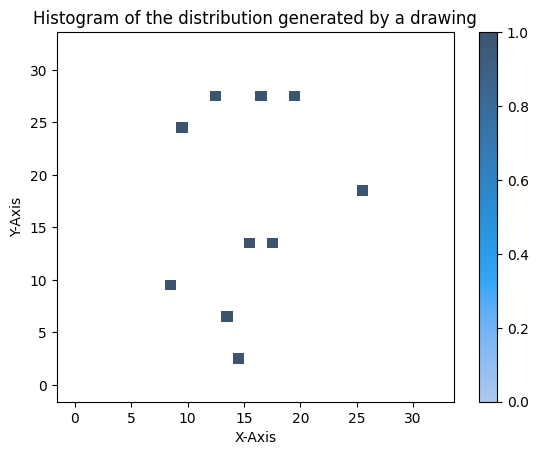

In [12]:
data = first_face.sample((1_000,))[:N_DATA]

shape = first_face.shape
data_coords = first_face.enumerate_support_()[data].cpu().numpy() + np.random.randn(len(data), 2) * 0.1

plotters.plot_histogram_from_points(data_coords, rotate=True, shape=shape, histplot_kwargs=dict(bins=shape[0]))
plt.show()

## Obtener GAN

De la misma manera, se puede definir un muestreador de distribuciones utilizando una GAN. Para ello, empezamos definiendo las redes neuronales a utilizar

In [13]:
from wgan_gp.wgan_gp_vae.model_resnet import Generator, Encoder, LatentDistribution
import torch
from wgan_gp.wgan_gp_vae.utils import load_checkpoint


device = conf.device

NOISE = "norm"
LATENT_DIM = 128
CHANNELS_IMG = 1
NUM_FILTERS = [256, 128, 64, 32]

noise_sampler = LatentDistribution(NOISE, LATENT_DIM, device)


G = Generator(LATENT_DIM, CHANNELS_IMG, latent_distr=NOISE).to(device)
E = Encoder(LATENT_DIM, CHANNELS_IMG).to(device)

DS_NAME = "data"
FACE_PATH = NETS_PATH / f"cleaned_{DS_NAME}_zDim{LATENT_DIM}_{NOISE}_bs_128"
ic(FACE_PATH)

load_checkpoint(G, FACE_PATH, "generator", device)
load_checkpoint(E, FACE_PATH, "encoder", device)

G.eval(); E.eval()
print()

ic| FACE_PATH: PosixPath('/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/wgan_gp/networks/cleaned_data_zDim128_norm_bs_128')


In [14]:
noise_sampler

LatentDistribution(name=norm, z_dim=128, device=cuda:0, dtype=torch.float32, seed=969225731198304)

torch.float32


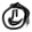

In [15]:
from bwb.distributions import DistributionDraw
from torchvision import disable_beta_transforms_warning
disable_beta_transforms_warning()

import torchvision.transforms.v2 as T


z = noise_sampler(1)
m = G(z)

transform_in = T.Compose([
    T.Lambda(lambda x: x / torch.max(x)),
    T.ToPILImage(),
    T.Resize(32),
    T.ToImage(),
    T.ConvertImageDtype(conf.dtype),
    T.Normalize((0.5,), (0.5,)),
])

transform_out_ = T.Compose([
    T.ToDtype(conf.dtype),
    T.Lambda(lambda x: x.squeeze()),
    T.Lambda(lambda x: x - torch.min(x)),
    T.Lambda(lambda x: x / torch.sum(x)),
])

transform_out = T.Compose([
    transform_out_,
    T.Lambda(lambda x: DistributionDraw.from_grayscale_weights(x)),
])


out: DistributionDraw = transform_out(m)
print(out.dtype)
out

## Definir Proyector

In [16]:
from wgan_gp.wgan_gp_vae.utils import ProjectorOnManifold
import torchvision.transforms.v2 as T

transform_in_proj = T.Compose([
    # From pdf to grayscale
    T.Lambda(lambda x: x / torch.max(x)),
    T.ToPILImage(),
    T.Resize((32, 32)),
    T.ToImage(),
    T.ToDtype(conf.dtype, scale=True),
    T.Normalize(
        [0.5 for _ in range(1)],
        [0.5 for _ in range(1)],
    ),
])

transform_out_proj = T.Compose([
    # Ensure the range is in [0, 1]
    T.Lambda(lambda x: x - torch.min(x)),
    T.Lambda(lambda x: x / torch.max(x)),
    T.Lambda(lambda x: x / torch.sum(x)),
    T.Lambda(lambda x: x.squeeze(0)),
])

proj = ProjectorOnManifold(
    E, G, 
    transform_in=transform_in_proj,
    transform_out=transform_out_proj,
)

## Definir $\gamma_k$

Aquí se utiliza una función de la forma
\begin{equation*}
    \gamma_k = \frac{a}{(b^{1/c} + k)^c}
\end{equation*}

Con $a > 0$, $b \geq 0$ y $0.5 < c \leq 1$

La idea es que cuando $k=0$, $\gamma_0 = \frac{a}{b}$ es la proporción entre $a$ y $b$, permitiendo ajustar el valor inicial.

In [17]:
from bwb.sgdw.utils import step_scheduler
window = 5

def test_gamma(gamma):

    for t in range(window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 50
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 100
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 300
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 500
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 1_000
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 3_000
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()

    init = 5_000
    for t in range(init, init+window):
        print(f"{t = :_}; {gamma(t) = :.2%}")
    print()


_a = 3
_eps = 1e-3
params = dict(a=_a, b=_a+1e-2, c=0.5+_eps)
# params = dict(a=1, b=1, c=1)

gamma = step_scheduler(**params)

test_gamma(step_scheduler(**params))

t = 0; gamma(t) = 99.67%
t = 1; gamma(t) = 94.55%
t = 2; gamma(t) = 90.15%
t = 3; gamma(t) = 86.31%
t = 4; gamma(t) = 82.93%

t = 50; gamma(t) = 38.89%
t = 51; gamma(t) = 38.57%
t = 52; gamma(t) = 38.25%
t = 53; gamma(t) = 37.94%
t = 54; gamma(t) = 37.63%

t = 100; gamma(t) = 28.60%
t = 101; gamma(t) = 28.47%
t = 102; gamma(t) = 28.34%
t = 103; gamma(t) = 28.21%
t = 104; gamma(t) = 28.09%

t = 300; gamma(t) = 16.97%
t = 301; gamma(t) = 16.94%
t = 302; gamma(t) = 16.91%
t = 303; gamma(t) = 16.89%
t = 304; gamma(t) = 16.86%

t = 500; gamma(t) = 13.21%
t = 501; gamma(t) = 13.20%
t = 502; gamma(t) = 13.19%
t = 503; gamma(t) = 13.18%
t = 504; gamma(t) = 13.16%

t = 1_000; gamma(t) = 9.38%
t = 1_001; gamma(t) = 9.37%
t = 1_002; gamma(t) = 9.37%
t = 1_003; gamma(t) = 9.37%
t = 1_004; gamma(t) = 9.36%

t = 3_000; gamma(t) = 5.43%
t = 3_001; gamma(t) = 5.42%
t = 3_002; gamma(t) = 5.42%
t = 3_003; gamma(t) = 5.42%
t = 3_004; gamma(t) = 5.42%

t = 5_000; gamma(t) = 4.20%
t = 5_001; gamma(t) = 4.2

## Definir distribución a posteriori con MCMC

In [18]:
NUTS_POSTERIOR_PATH = NUTS_PATH / f"bayes-bar-n_data-{N_DATA}-burn-{BURN:_}-num_samples-{NUM_SAMPLES:_}-n_walkers-{N_WALKERS}"
NUTS_POSTERIOR_PATH = NUTS_POSTERIOR_PATH.with_suffix(".pkl.gz")
print(NUTS_POSTERIOR_PATH)

POST_DATA_PATH = CURR_PATH / "data"  # / f"n_data-{N_DATA}.pkl"
POST_DATA_PATH.mkdir(parents=True, exist_ok=True)
DATA_PATH_ = POST_DATA_PATH / f"n_data-{N_DATA}-burn-{BURN:_}-num_samples-{NUM_SAMPLES:_}-n_walkers-{N_WALKERS}.pkl"
print(DATA_PATH_)

/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/saved_mcmc/NUTS/bayes-bar-n_data-10-burn-5_000-num_samples-100_000-n_walkers-32.pkl.gz
/home/fmunoz/codeProjects/pythonProjects/Bayesian-Learning-with-Wasserstein-Barycenters/examples/03-sgdw/data/n_data-10-burn-5_000-num_samples-100_000-n_walkers-32.pkl


In [20]:
import pickle


if not NUTS_POSTERIOR_PATH.exists() or RUN_MCMC:
    post_pi_n = NUTSPosteriorSampler(
        n_walkers=N_WALKERS,
        num_steps_per_sample=1,
        burn=BURN,
        desired_accept_rate=0.6,
        use_half=True,
    ).fit(
        G, transform_out_, noise_sampler, data,
    )

    with logging.register_total_time(_log) as timer:
        post_pi_n.run(n_steps=NUM_SAMPLES)
    ic(timer.elapsed_time)

    with logging.register_total_time(_log) as timer:
        autocorr_time = post_pi_n.get_autocorr_time()
    ic(timer.elapsed_time)

    with logging.register_total_time(_log) as timer:
        post_pi_n.save(NUTS_POSTERIOR_PATH)
    ic(timer.elapsed_time)

    with open(DATA_PATH_, "wb") as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)    
    
else:
    if ic(DATA_PATH_.exists()):
        with open(DATA_PATH_, "rb") as f:
            data = pickle.load(f)
            
    with logging.register_total_time(_log) as timer:
        post_pi_n = NUTSPosteriorSampler.load(NUTS_POSTERIOR_PATH)
        post_pi_n.fit(G, transform_out_, noise_sampler, data)
    ic(timer.elapsed_time)

    with logging.register_total_time(_log) as timer:
        autocorr_time = post_pi_n.get_autocorr_time()
    ic(timer.elapsed_time)

post_pi_n

ic| DATA_PATH_.exists(): True
ic| timer.elapsed_time: 622.2387968380062
ic| timer.elapsed_time: 5.5378391520062


NUTSPosteriorSampler(n_data=10, len_chain=100_000, n_steps=3_200_000, n_walkers=32)

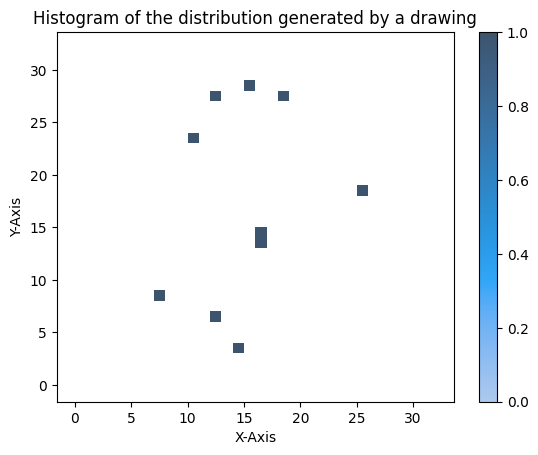

In [21]:
shape = first_face.shape
data_coords = first_face.enumerate_support_()[data].cpu().numpy() + np.random.randn(len(data), 2) * 0.1

fig, _ = plotters.plot_histogram_from_points(data_coords, rotate=True, shape=shape, histplot_kwargs=dict(bins=shape[0]))
save_fig(fig, f"n_data-{N_DATA}")
plt.show()

In [22]:
post_pi_n.mean_autocorr_time

tensor(260.7031, device='cuda:0')

In [23]:
# mean_autocorr_time = int(autocorr_time.mean())
# ic(mean_autocorr_time)
# max_autocorr_time = int(autocorr_time.max())
# ic(max_autocorr_time)

post_pi_n.shuffle_samples_cache()

NUTSPosteriorSampler(n_data=10, n_cached_samples=12_320, len_chain=100_000, n_steps=3_200_000, n_walkers=32)

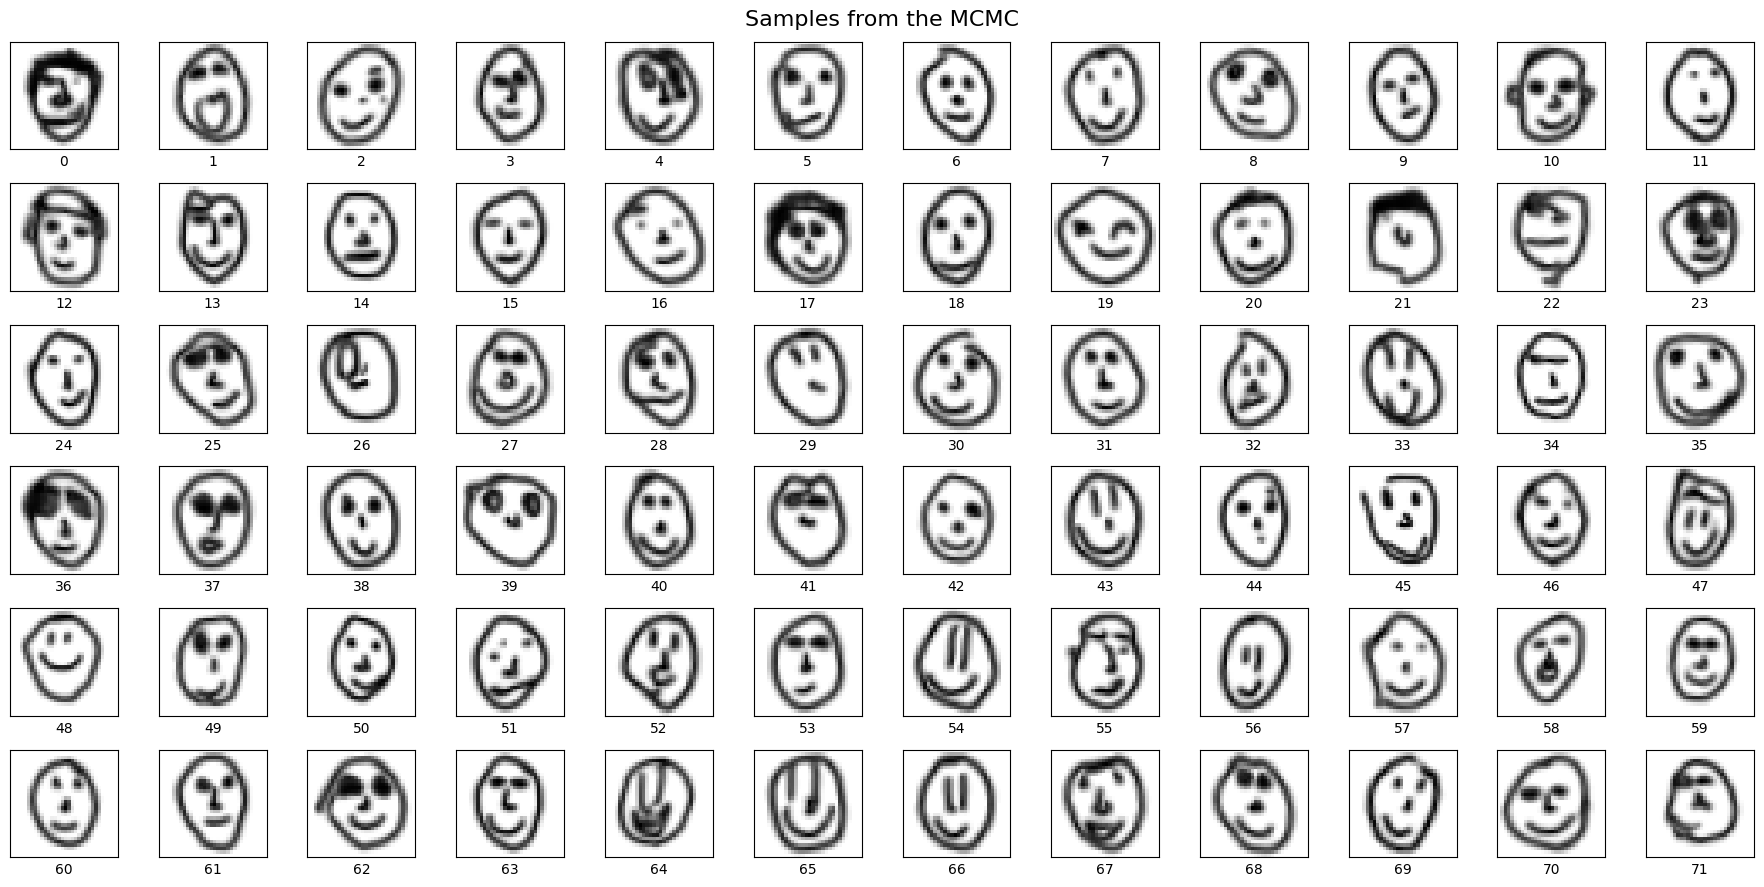

In [24]:
from copy import copy
post_pi_n_ = copy(post_pi_n)
n_rows, n_cols = 6, 12
max_imgs = n_rows * n_cols
fig, ax = plotters.plot_list_of_draws(
    post_pi_n_.sample(max_imgs), 
    n_rows=n_rows, n_cols=n_cols,
    title=f"Samples from the MCMC"
)
save_fig(fig, f"n-data-{N_DATA}-{post_pi_n.__class__.__name__}-{n_rows}x{n_cols}")
del post_pi_n_

# Cálculo del Baricentro

In [25]:
dist_draw_sgdw = sgdw.DebiesedDistributionDrawSGDW(
    distr_sampler=post_pi_n,
    step_scheduler=gamma,
    batch_size=BATCH_SIZE,
    projector=proj,
    proj_every=PROJ_EVERY,
    max_iter=MAX_ITER,
    report_every=REPORT_EVERY,
)
dist_draw_sgdw.det_params, dist_draw_sgdw.hist

(DetentionParameters(tol=0.00e+00, max_iter=5_000, max_time=∞),
 History(pos_wgt=False, distr=False, pos_wgt_samp=False, distr_samp=False, len=0))

In [26]:
from bwb.sgdw.plotters import PlotterComparison

plotter_comp = PlotterComparison(
    dist_draw_sgdw,
    plot_every=None,
    n_cols=12,
    n_rows=2,
    cmap="binary_r"
)

In [27]:
_log.info(f"Running SGD-Wasserstein with '{DS_NAME}' bayesian projected barycenter")
with logging.register_total_time(_log) as timer:
    bar = plotter_comp.run(include_dict=dict(total_time=True))
ic(timer.elapsed_time)
dist_draw_sgdw.iter_params

ic| timer.elapsed_time: 1065.2426500900183


IterationParameters(k=5_000, w_dist=∞, t=0:17:45.19, Δt=156.05 [ms])

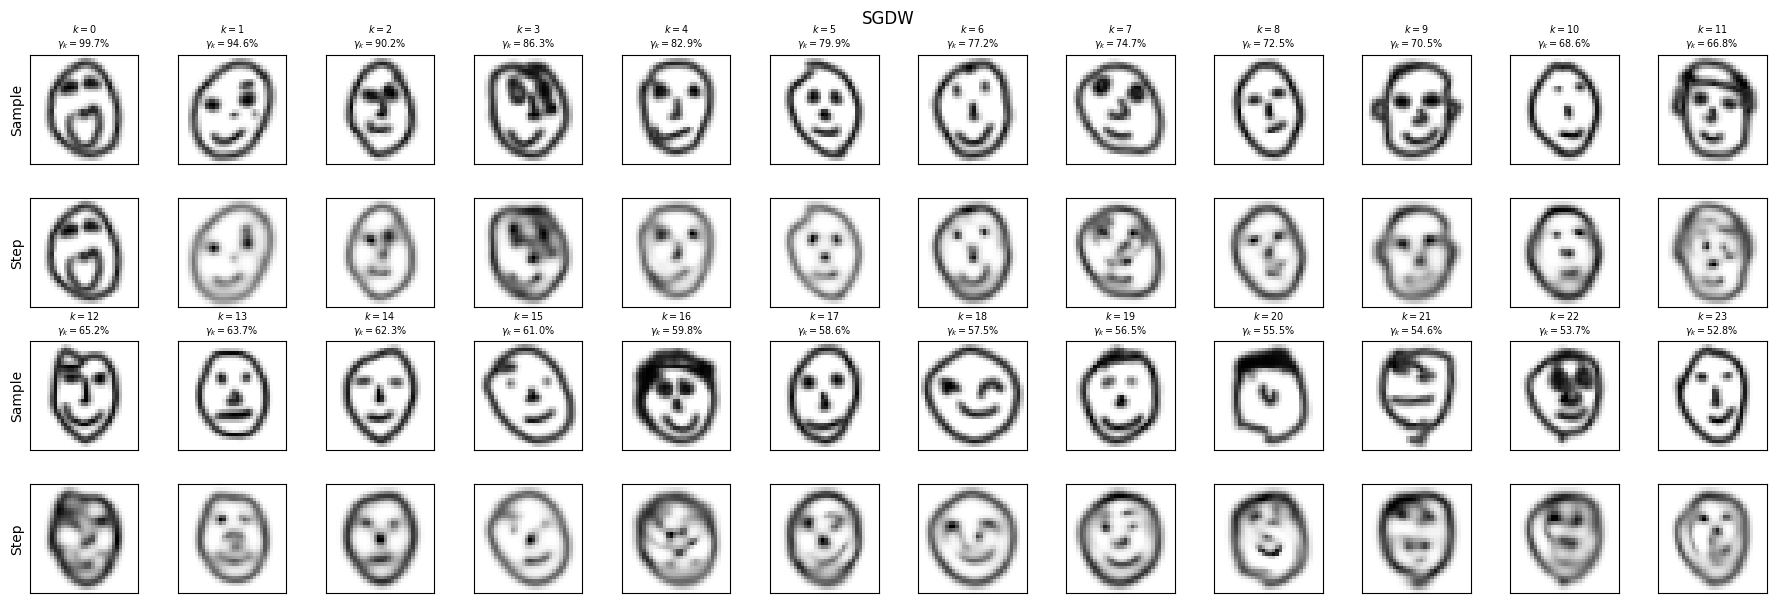

In [28]:
fig, _ = plotter_comp.plot(0)
save_fig(fig, "first-iters")

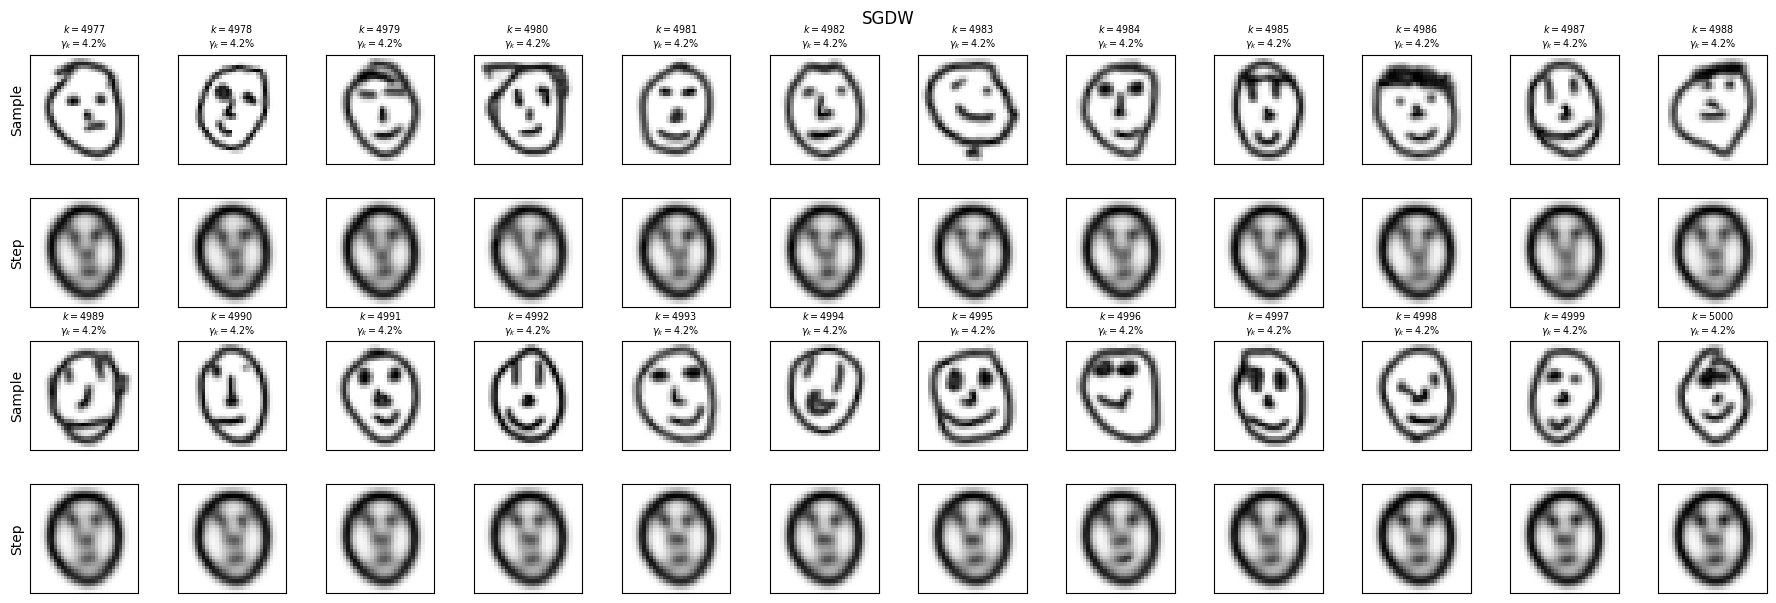

In [29]:
fig, _ = plotter_comp.plot()
save_fig(fig, "last-iters")